Start with our usual setup, including the utility methods from last time.

In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from time import time
import math


# Make matplotlib figures appear inline in the
# notebook rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# provide methods for loading and displaying images
def load(image_path):
    out = io.imread(image_path)
    out = out.astype(np.float64) / 255
    return out

def display(img, title=None):
    # Show image
    plt.figure(figsize = (5,5))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
# As usual, you may use your own images, but you must include them in your submission.
image_path = './dog.jpg'

image = load(image_path)

We provide a naive implementation of a grayscale convolutional filter:

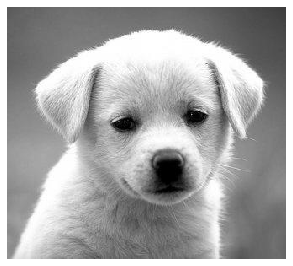

In [12]:
def naive_convolution_filter(image, kernel):
    """
    Args:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk).
    Returns:
        out: numpy array of shape (Hi, Wi).
    """
    out = np.zeros(image.shape)
    
    for image_row in range(image.shape[0]):
        for image_column in range(image.shape[1]):
            output_value = 0
            for kernel_row in range(kernel.shape[0]):
                for kernel_column in range(kernel.shape[1]):
                    image_row_offset = math.ceil(kernel_row - kernel.shape[0] / 2)
                    image_column_offset = math.ceil(kernel_column - kernel.shape[1] / 2)
                    
                    if (image_row + image_row_offset < 0 or 
                        image_row + image_row_offset >= image.shape[0] or
                        image_column + image_column_offset < 0 or 
                        image_column + image_column_offset >= image.shape[1]):
                        image_value = 0
                    else:
                        image_value = image[image_row + image_row_offset, image_column + image_column_offset]

                    output_value += image_value * kernel[kernel_row, kernel_column]

            out[image_row, image_column] = output_value
            
    return out

display(image)

## Exercise 1

1. Take a look at the filters in the following code cell. What do you think they do? You may want to run display() on the filter to visualize it.

prediction: filter 1 will crop two pixels off of the top and bottom but crop four pixels off of the left

prediction: filter 2 will double the brightness

prediction: filter 3: if the surrounding pixels are the same color as the focused pixel, nothing will change. If they are brighter, the focused pixel will be dimmer. If they are dimmer, the focused pixel will be brighter.

2. Run the filters using `naive_convolution_filter` to verify your answer.

result: filter 1 moved the image two pixels to the left (and in doing so created a two pixel wide black column on the right side of the image). This happens because the kernel starts centered on the top left corner of the image, so its top two 0's are off the top of the screen and the left two 0's are off the left of the screen but the middle two 0 columns mean that the filter cannot capture the two leftmost columns. Since the 1 in the kernel starts on the third column, the third column becomes the first column after the filter is applied. When the filter is at the right side of the screen, for the last two pixels, there will be no 1's in the kernel that overlap with the image so they will show up black.

Lesson: the kernel runs centered on each pixel of the image.

result: filter 2 doubled the brightness of the image but some values went over the maximum displayable value of 1, so they show up as white (1) in the final image. As a result, detail in the lighter / brighter sections is lost.

result: filter 3: the resulting image is visually similar to the original but details in smooth parts of the fur are more contrasting. This is called a sharpening filter as it increases local contrast. The effect is much more significant with -0.5/5 instead of -0.11/1.88 (default)

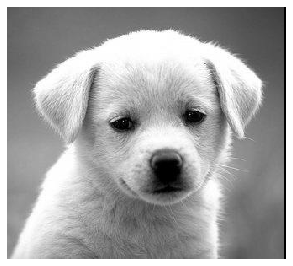

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


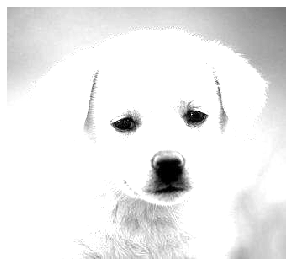

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


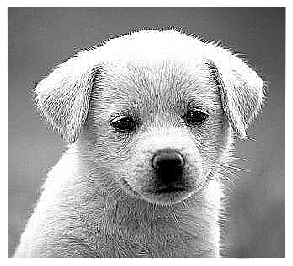

In [13]:
filter1 = np.array(
[
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,0,1],
    [0,0,0,0,0],
    [0,0,0,0,0]
])

filter2 = np.array(
[
    [0,0,0],
    [0,2,0],
    [0,0,0]
])

# Hint: check the lecture slides for a familiar-looking filter
filter3 = np.array(
[
    [-.5,-.5,-.5],
    [-.5, 5, -.5],
    [-.5,-.5,-.5],
])

display(naive_convolution_filter(image, filter1))
display(naive_convolution_filter(image, filter2))
display(naive_convolution_filter(image, filter3))

## Exercise 2
The naive implementation only works on grayscale images. Create an implementation that works on color images. You may choose to apply the same filter to all three channels, or you may take multiple filters as input and apply them separately to each channel. 

Submit the output of at least one filter on at least one color image.

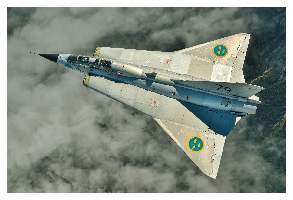

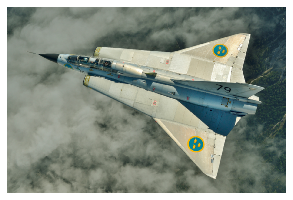

exec time: 12.911057710647583


In [16]:
def single_channel_filter(filter_, image_slice, channel_id=0):
    # pad the image slice
    filter_x_radius = math.floor(filter_.shape[1] / 2)
    filter_y_radius = math.floor(filter_.shape[0] / 2)
    
    padded_image_slice = np.pad(image_slice, ((filter_y_radius, filter_y_radius), (filter_x_radius, filter_x_radius)),
                          'constant', constant_values=(0,0))
    
    
    # apply the filter
    filtered_slice = np.zeros(image_slice.shape)
    
    for y in range(0, image_slice.shape[0]):
        for x in range(0, image_slice.shape[1]):
            filtered_slice[y][x] = np.sum(filter_ * \
                padded_image_slice[y:y + filter_.shape[0], x:x + filter_.shape[1]])
    
    return filtered_slice, channel_id

# https://stackoverflow.com/questions/10415028/how-can-i-recover-the-return-value-of-a-function-passed-to-multiprocessing-proce
def threaded_single_channel_filter(queue, filter_, image_slice, channel_id):
    queue.put(single_channel_filter(filter_, image_slice, channel_id))

def rgb_filter(filters, image_):
    if len(filters.shape) == 2:
        filters = 3 * [filters]
    else:
        assert(len(filters) == image_.shape[2])
    
    filter_threads = []
    image_slices = 3 * [0]
    q = multiprocessing.Queue()
    
    for i, f in enumerate(filters):
        proc = multiprocessing.Process(target=threaded_single_channel_filter, args=(q, f, image_[:, :, i], i))
        filter_threads.append(proc)
        proc.start()
        
    for f in filter_threads:
        slice_ = q.get()
        image_slices[slice_[1]] = slice_[0]
    
    for f in filter_threads:
        f.join()

    return np.dstack(image_slices) # dstack concatenates along a third axis



## Exercise 3
Create your own filter(s) and describe their output.

## Advanced exercise 1

Recall from lecture that at the edges, filters only partially overlap with the image pixels, so we need a way to provide numbers that are out of bounds. The provided implementation uses the strategy we discussed in lecture, zero-padding, which just treats all out-of-bounds pixels as zero.

A different strategy is edge value replication: treat all out-of-bounds pixels as having the same value as the closest in-bounds pixel. Another one is mirror extension: treat the border of the image as a mirror, and use the pixel value that would be reflected into the out-of-bounds space. These are not the only strategies -- you're welcome to research others on your own.

Modify naive_convolutional_filter to implement one or more of these strategies. How does that change the output of filters?

## Advanced exercise 2

You may have noticed that `naive_convolutional_filter` is quite slow. Create an implementation that is faster, using the `time` library to demonstrate the difference in performance. Your implementation must return the same output as the naive implementation.


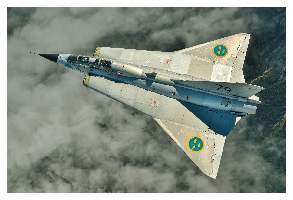

my implementation's time: 12.599486112594604
naive implementation's time: 64.34418225288391
equal results: True


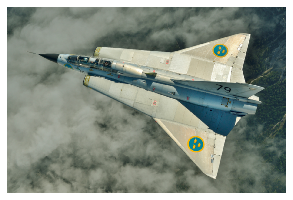

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


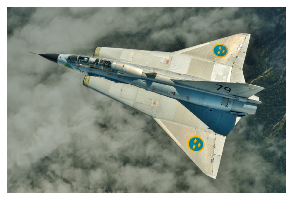

In [23]:
# My implementation for exercise 2 essentially does this, here is a direct comparison

test_filter = 1. / 9. * np.ones((3,3)) # smoothing http://vision.stanford.edu/teaching/cs131_fall1920/slides/02_filters.pdf

test_image = load('./draken.jpg')
display(test_image)

start = time()
my_implementation = rgb_filter(test_filter, test_image) # 12.344209909439087s on my hardware
end = time()
print("my implementation's time: " + str(end - start))

start = time()
naive_implementation = naive_convolution_filter(test_image, test_filter) # 63.57145810127258s on my hardware
end = time()
print("naive implementation's time: " + str(end - start))

print("equal results: " + str(np.allclose(naive_implementation, my_implementation))) # doesn't work with array_equal but they visually look equal so my guess is floating point errors

display(my_implementation)
display(naive_implementation)